In [1]:
# Import necessary packages
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
#import shap
import os
import seaborn as sns
import time
import pickle

sns.set()

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]

C:\Users\GHOST\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read csv file containing training datadata
train_df = pd.read_csv("D:/Xray_Data/data/small_data/nih/train-small.csv")
valid_df = pd.read_csv("D:/Xray_Data/data/small_data/nih/valid-small.csv")
test_df = pd.read_csv("D:/Xray_Data/data/small_data/nih/test.csv")
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the train data frame')
train_df.head()

There are 1000 rows and 16 columns in the train data frame


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [3]:
print(f"Train set: The total patient ids are {train_df['PatientId'].count()}, from those the unique ids are {train_df['PatientId'].value_counts().shape[0]} ")
print(f"Validation set: The total patient ids are {valid_df['PatientId'].count()}")
print(f"Test set: The total patient ids are {test_df['PatientId'].count()}")

Train set: The total patient ids are 1000, from those the unique ids are 928 
Validation set: The total patient ids are 200
Test set: The total patient ids are 420


In [4]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) > 0 
    
    ### END CODE HERE ###
    
    return leakage

In [5]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


In [6]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['Image', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'PatientId', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [7]:
# Remove unnecesary elements
columns.remove('Image')
columns.remove('PatientId')
# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")
# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

There are 14 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
The class Atelectasis has 106 samples
The class Cardiomegaly has 20 samples
The class Consolidation has 33 samples
The class Edema has 16 samples
The class Effusion has 128 samples
The class Emphysema has 13 samples
The class Fibrosis has 14 samples
The class Hernia has 2 samples
The class Infiltration has 175 samples
The class Mass has 45 samples
The class Nodule has 54 samples
The class Pleural_Thickening has 21 samples
The class Pneumonia has 10 samples
The class Pneumothorax has 38 samples


Display Random Images


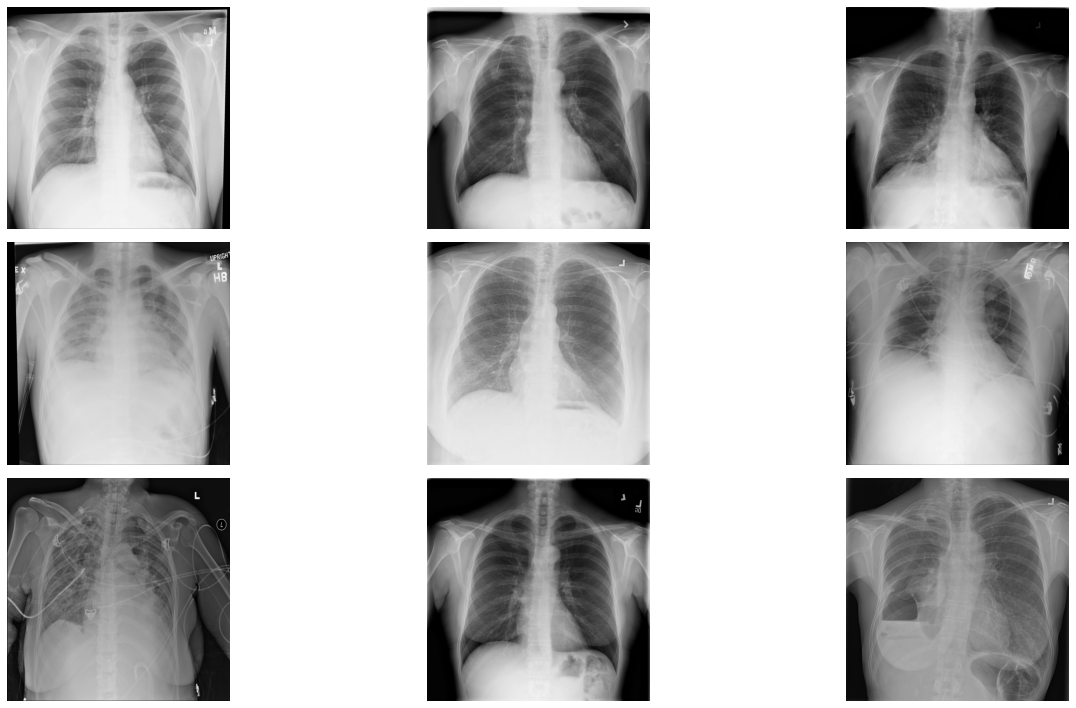

In [8]:
# Extract numpy values from Image column in data frame
images = train_df['Image'].values

# Extract 9 random images from it
random_images = [np.random.choice(images) for i in range(9)]

# Location of the image dir
img_dir = 'D:/Xray_Data/data/small_data/nih/images-small/'

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout() 

C:\Users\GHOST\AppData\Local\Temp\ipykernel_136\2148262833.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 0.9804 and the minimum is 0.0000
The mean value of the pixels is 0.4796 and the standard deviation is 0.2757


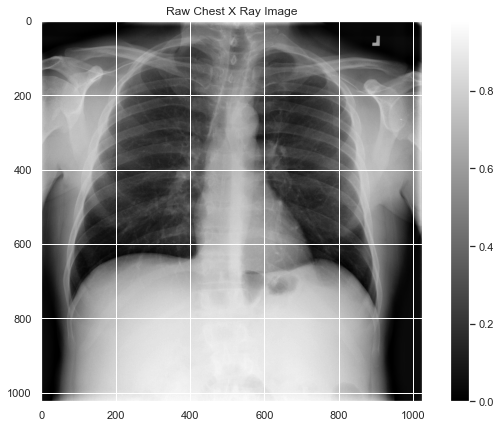

In [9]:
# Get the first image that was listed in the train_df dataframe
sample_img = train_df.Image[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

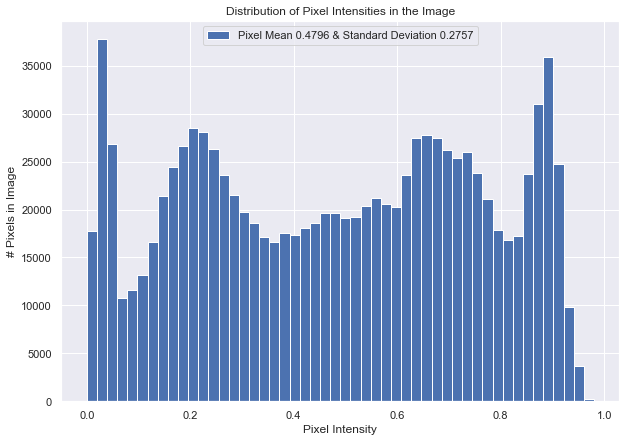

In [10]:
pixels = np.reshape(raw_image,raw_image.shape[0]*raw_image.shape[1])
plt.hist(pixels, bins=50, label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

In [11]:
# Import data generator from keras https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # Normalize images  --- Generate batches of tensor image data with real-time data augmentation
    image_generator = ImageDataGenerator(
        samplewise_center=True,              #Set each sample mean to 0
        samplewise_std_normalization= True)  # Divide each input by its standard deviation
    
    # flow from directory with specified batch size and target image size
    # flow_from_dataframe ==> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    # RETURNS a DataFrameIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with 
    # shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels
    # default data format of ImageGenerator is channels_last
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",       #  Mode for yielding the targets, one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical".
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, 
                                 seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    # get generator to sample dataset
    print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")

    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    #batch = raw_train_generator.next() # generate a batch of samples and associated labels 
    data_sample = next(raw_train_generator)[0]           # => we need only the sample imgs ie batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data - we use this generator normalizing mean and std using the train sample of 100
    image_generator.fit(data_sample)
    
    print("\ngetting valid generator...")

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    print("\ngetting test generator...")
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [ ]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']
IMAGE_DIR = "D:/Xray_Data/data/small_data/nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

In [ ]:
# Plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [ ]:
print(generated_image.shape, generated_image[0].shape)
print(raw_image.shape)

In [ ]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for original iamge
sns.distplot(raw_image.ravel(), 
             label=f'Original Image: mean {np.mean(raw_image):.4f} - Standard Deviation {np.std(raw_image):.4f} \n '
             f'Min pixel value {np.min(raw_image):.4} - Max pixel value {np.max(raw_image):.4}',
             color='blue', 
             kde=False)

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(), 
             label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}', 
             color='red', 
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.show()

In [ ]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = (N - np.sum(labels, axis=0))/N  # broadcasting of N to a line vector of dim num_classes

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have defined labels and freq_pos, freq_neg

# Create DataFrame for positive labels
data_pos = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})

# Create DataFrame for negative labels
data_neg = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)])

# Concatenate data_pos and data_neg
data = pd.concat([data_pos, data_neg], ignore_index=True)

# Plot
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()


In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have defined labels, pos_contribution, neg_contribution

# Create DataFrame for positive labels
data_pos = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})

# Create DataFrame for negative labels
data_neg = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(neg_contribution)])

# Concatenate data_pos and data_neg
data = pd.concat([data_pos, data_neg], ignore_index=True)

# Plot
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data)
plt.show()


In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += - pos_weights[i] * K.mean(y_true[:,i] * K.log(y_pred[:,i] + epsilon)) \
            - neg_weights[i] * K.mean((1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon)) #complete this line
        return loss
    
        ### END CODE HERE ###
    return weighted_loss     

In [ ]:
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.preprocessing import image

def load_C3M3_model():
   
    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total
    print("Got loss weights")
    # create the base pre-trained model
    base_model = DenseNet121(weights="D:/Xray_Data/data/small_data/nih/densenet.hdf5", include_top=False)
    print("Loaded DenseNet")
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # and a logistic layer
    predictions = Dense(len(labels), activation="sigmoid")(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer='adam', loss=get_weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")

    model.load_weights("D:/Xray_Data/data/small_data/nih/pretrained_model.h5")
    print("Loaded Weights")
    return model

In [ ]:
model = load_C3M3_model()

In [ ]:
model.summary()

In [ ]:
# Print out the total number of layers
layers_ = model.layers
print('total number of layers =',len(layers_))

In [ ]:
# The find() method returns an integer value:
# If substring doesn't exist inside the string, it returns -1, otherwise returns first occurence index
conv2D_layers = [layer for layer in model.layers 
                if str(type(layer)).find('Conv2D') > -1]

In [ ]:
print('Model input -------------->', model.input)
print('Feature extractor output ->', model.get_layer('conv5_block16_concat').output)
print('Model output ------------->', model.output)

In [ ]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))
predicted_vals.shape  # number of test samples x number of classes to predict

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.savefig('ROC.png')
    plt.show()
    return auc_roc_vals

In [ ]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [ ]:
print("areas under the curve : {} \n for all {} classes".format(auc_rocs,len(auc_rocs)))

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

# Update the load_image function to use the correct load_img function
def load_image(path, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    x = load_img(path, target_size=(H, W))
    if preprocess:
        mean, std = get_mean_std_per_batch(df, H=H, W=W)
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

im_path = IMAGE_DIR + '00025288_001.png' 
x = load_image(im_path, train_df, preprocess=False)
plt.imshow(x, cmap='gray')
plt.show()


In [ ]:

from tensorflow.keras.preprocessing.image import load_img

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    mean, std = get_mean_std_per_batch(image_dir, df, H=H, W=W)
    img_path = os.path.join(image_dir, img)
    x = load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

def get_mean_std_per_batch(image_dir, df, H=320, W=320):
    sample_data = []
    for img in df.sample(100)["Image"].values:
        image_path = os.path.join(image_dir, img)
        sample_data.append(np.array(load_img(image_path, target_size=(H, W))))
    
    mean = np.mean(sample_data, axis=(0, 1, 2, 3))
    std = np.std(sample_data, axis=(0, 1, 2, 3), ddof=1)
    return mean, std


In [ ]:
# Assuming you have already defined `im_path`, `load_image_normalize`, and `model`

# Compute mean and std
mean, std = get_mean_std_per_batch(train_df)

# Load and preprocess the image
processed_image = load_image_normalize(im_path, mean, std)

# Make predictions
preds = model.predict(processed_image)

# Create a DataFrame for predictions
pred_df = pd.DataFrame(preds, columns=labels)

# Plot the predictions
pred_df.loc[0, :].plot.bar()
plt.title("Predictions")
plt.savefig('predictions.png')
plt.show()


In [ ]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

processed_image = load_image_normalize(im_path, mean, std)
preds = model.predict(processed_image)
pred_df = pd.DataFrame(preds, columns = labels)
pred_df.loc[0, :].plot.bar()
plt.title("Predictions")
plt.savefig('predictions.png')
plt.show()


In [ ]:
pred_df

In [ ]:
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing import image
import pandas as pd
import numpy as np

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += - pos_weights[i] * K.mean(y_true[:,i] * K.log(y_pred[:,i] + epsilon)) \
            - neg_weights[i] * K.mean((1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon)) #complete this line
        return loss
    
    return weighted_loss

def load_C3M3_model():
    train_df = pd.read_csv("D:/all_images/small_data/nih/train-small.csv")  # Change this to your training data file path
    IMAGE_DIR = "D:/all_images/small_data/nih/images-small/"  # Change this to your image directory path

    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total
    print("Got loss weights")

    # create the base pre-trained model
    base_model = DenseNet121(weights='D:/all_images/densenet.hdf5', include_top=False)
    print("Loaded DenseNet")

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # and a logistic layer
    predictions = Dense(len(labels), activation="sigmoid")(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss=get_weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")

    model.load_weights("D:/all_images/pretrained_model.h5")
    print("Loaded Weights")
    
    # Save the model architecture and weights
    model.save("D:/all_images/final_saved_models/chest_xray_model_small.h5")
    print("Saved Model")
    
    return model

model = load_C3M3_model()


In [ ]:
df = pd.read_csv("D:/Xray_Data/data/small_data/nih/train-small.csv")
IMAGE_DIR = "D:/Xray_Data/data/small_data/nih/images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]


In [ ]:
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)


In [ ]:
import util

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    mean, std = get_mean_std_per_batch(image_dir, df, H=H, W=W)
    img_path = os.path.join(image_dir, img)
    x = load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

def get_mean_std_per_batch(image_dir, df, H=320, W=320):
    sample_data = []
    for img in df.sample(100)["Image"].values:
        image_path = os.path.join(image_dir, img)
        sample_data.append(np.array(load_img(image_path, target_size=(H, W))))
    
    mean = np.mean(sample_data, axis=(0, 1, 2, 3))
    std = np.std(sample_data, axis=(0, 1, 2, 3), ddof=1)
    return mean, std


In [ ]:
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema

In [ ]:
#Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema

In [ ]:
def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam
def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1

In [ ]:
compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    mean, std = get_mean_std_per_batch(img, df, H=H, W=W)
    img_path = os.path.join(image_dir, img)
    x = load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(load_img(image_path, target_size=(H, W))))
    
    mean = np.mean(sample_data, axis=(0, 1, 2, 3))
    std = np.std(sample_data, axis=(0, 1, 2, 3), ddof=1)
    return mean, std


In [ ]:
compute_gradcam(model, "D:/WhatsApp Image 2024-03-11 at 12.55.49_b33e74b2.jpg", IMAGE_DIR, df, labels, labels_to_show)

In [ ]:
import tensorflow as tf

def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """Compute GradCAM for a specific class index."""
    with tf.compat.v1.keras.backend.get_session().graph.as_default():
        y_c = input_model.output[0, cls]
        conv_output = input_model.get_layer(layer_name).output
        grads = tf.gradients(y_c, conv_output)[0]
        
        gradient_function = tf.keras.backend.function([input_model.input], [conv_output, grads])
        output, grads_val = gradient_function([image])
    
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # ReLU
    cam /= np.max(cam)  # Normalize
    
    return cam


In [ ]:
grad_cam(model, "D:/WhatsApp Image 2024-03-11 at 12.55.49_b33e74b2.jpg", IMAGE_DIR, train_df, labels, labels)

In [ ]:
import tensorflow as tf

def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """Compute GradCAM for a specific class index."""
    with tf.compat.v1.keras.backend.get_session().graph.as_default():
        y_c = input_model.output[0, cls]
        conv_output = input_model.get_layer(layer_name).output
        grads = tf.gradients(y_c, conv_output)[0]
        
        gradient_function = tf.compat.v1.keras.backend.function([input_model.input], [conv_output, grads])
        output, grads_val = gradient_function([image])
    
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # ReLU
    cam /= np.max(cam)  # Normalize
    
    return cam


In [ ]:
grad_cam(model, "D:/WhatsApp Image 2024-03-11 at 12.55.49_b33e74b2.jpg", IMAGE_DIR, train_df, labels, labels)

In [ ]:
df = pd.read_csv("nih/train-small.csv")
IMAGE_DIR = "nih/images-small/"

# only show the labels with top 4 AUنوه9نهC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]